In [1]:
from pathlib import Path
from matplotlib import pyplot as plt

import numpy as np

from jaxpower import Spectrum2Poles, WindowMatrix, CovarianceMatrix, BinnedStatistic
from abacus_hf import get_measurement_fn, get_box_measurement_fn

rebin = 5
nmocks = 25
catalog_args = dict(zsnap=0.950, region='NGC', tracer='LRG', zrange=(0.8, 1.1))
imock = 0

fns = [get_measurement_fn(imock=0, **catalog_args, kind='covariance_mesh2spectrum').replace('.npy', f'_{key}.npy') for key in ['ww', 'ws', 'ss']]
covs = [CovarianceMatrix.load(fn).slice(slice(0, None, 5)) for fn in fns]

fns = [get_measurement_fn(imock=0, **catalog_args, kind='covariance_mesh2spectrum_fftlog').replace('.npy', f'_{key}.npy') for key in ['ww', 'ws', 'ss']]
covs_fftlog = [CovarianceMatrix.load(fn).slice(slice(0, None, 5)) for fn in fns]

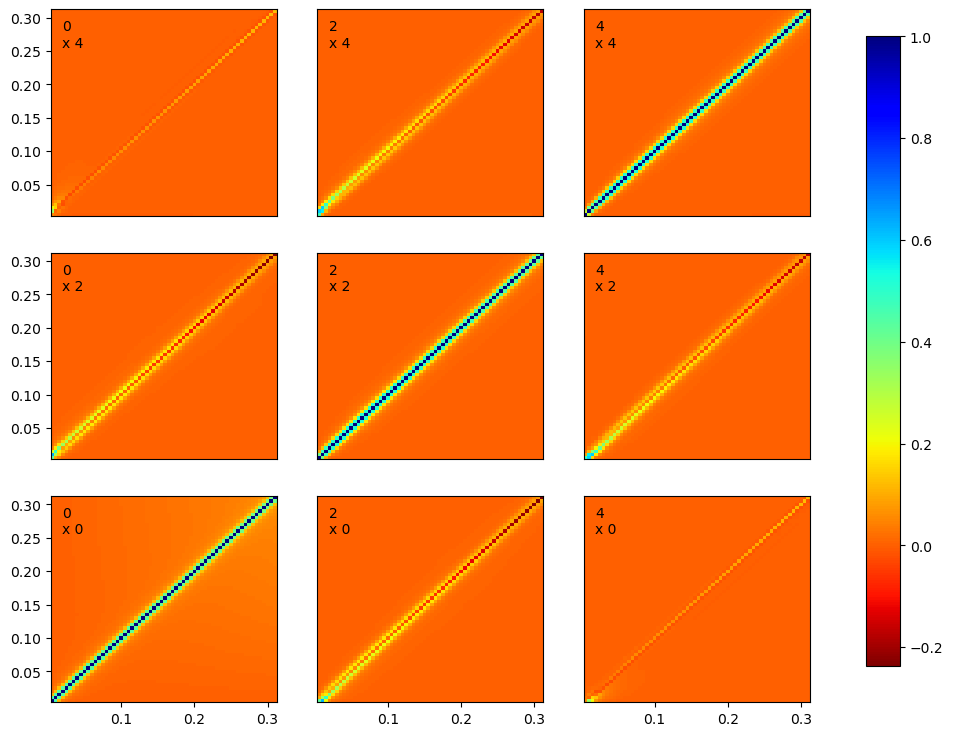

In [7]:
cov = sum(covs)
cov.plot(corrcoef=True, show=True);

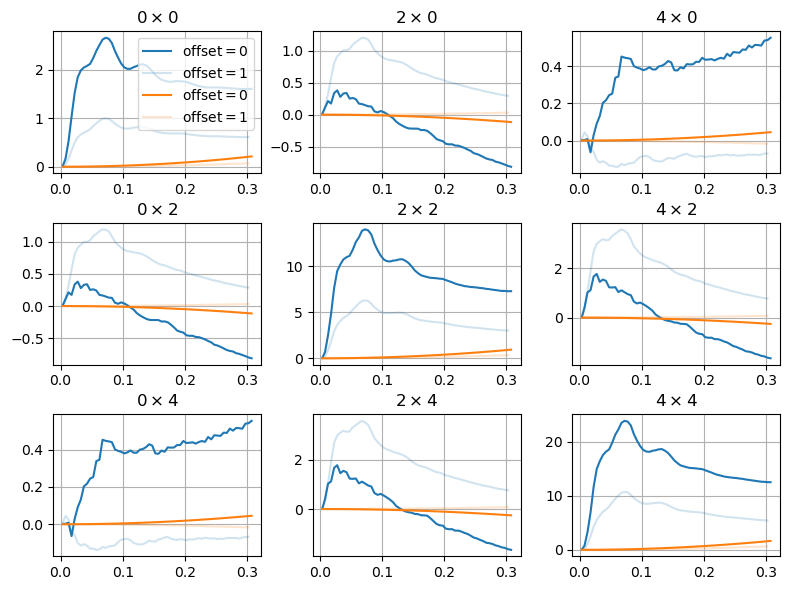

In [5]:
kw = dict(offset=[0, 1], ytransform=lambda x, y: x**4 * y)

fig = sum(covs).plot_diag(**kw, color='C0')
covs[2].plot_diag(**kw, color='C1', fig=fig, show=True);